In [31]:
import tensorflow as tf
import zipfile
import lxml.etree
import re
import urllib.request
import os
import numpy as np

from tqdm import tqdm

In [2]:
# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

## Data Preparation

In [34]:
def parse(doc):
    return [(f.xpath("./content/text()")[0], f.xpath("./head/keywords/text()")[0]) for f in doc.xpath("//file")]

def label(keywords):
    kwset = set([kw.strip().lower() for kw in keywords.split(",")])
    lbl = np.zeros(8)
    lbl[4 * ("technology" in kwset) + 2 * ("entertainment" in kwset) + 1 * ("design" in kwset)] = 1
    return lbl

def tokenise(text):
    input_text_noparens = re.sub(r'\([^)]*\)', '', text)
    sentence_strings = []
    for line in input_text_noparens.split('\n'):
        m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
        sentence_strings.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)
    return re.sub(r"[^a-z0-9]+", " ", ' '.join(sentence_strings).lower()).split()

with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))

examples = tqdm(parse(doc), desc='Processing talks', unit='talks')
all_data_raw = [(tokenise(content), label(keywords)) for (content, keywords) in examples]
all_content = [content for content, _ in all_data_raw]
all_labels = [label for _, label in all_data_raw]

del doc

print(all_content[0][:30])
print(all_labels[0])

Processing talks: 100%|██████████| 2085/2085 [00:02<00:00, 861.27talks/s]

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new', 'to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is']
[ 1.  0.  0.  0.  0.  0.  0.  0.]


Split into training and test sets:

In [44]:
from sklearn.model_selection import train_test_split

train_content, test_content, train_labels, test_labels = train_test_split(all_content, all_labels, test_size=0.05, random_state=1234)
print(train_content[0][:30])
print(train_labels[0])

['you', 'know', 'when', 'chris', 'first', 'approached', 'me', 'to', 'speak', 'at', 'ted', 'i', 'said', 'no', 'because', 'i', 'felt', 'like', 'i', 'wasn', 't', 'going', 'to', 'be', 'able', 'to', 'make', 'that', 'personal', 'connection']
[ 0.  0.  1.  0.  0.  0.  0.  0.]


Convert words to numbers:

In [45]:
from collections import Counter
word_counts = Counter()

contents_pbar = tqdm(train_content, desc='Counting words', unit='examples')

for content in contents_pbar:
    word_counts.update(content)

print(word_counts.most_common(20))

# remove some of the least frequent words to ensure we have some unknown words in training and test sets
vocabulary = [word for (word, cnt) in word_counts.most_common()][:-454]
word_index = dict(zip(vocabulary, range(len(vocabulary))))

print(word_index['awesome'])

Counting words: 100%|██████████| 1980/1980 [00:00<00:00, 2924.41examples/s]


[('the', 197204), ('and', 142144), ('to', 118739), ('of', 108878), ('a', 99972), ('that', 90277), ('i', 79515), ('in', 73985), ('it', 70881), ('you', 67610), ('we', 63922), ('is', 59930), ('s', 54204), ('this', 46739), ('so', 35118), ('they', 31490), ('was', 29429), ('for', 28159), ('are', 26582), ('have', 25886)]
2006


Convert to one-hot vectors. This will be done on the fly, as the vectors are large.

In [46]:
word_ohv_size = len(vocabulary) + 1 # +1 for unknown words
print("word one-hot vector size: ", word_ohv_size)

def word2ohv(word):
    result = np.zeros(word_ohv_size)
    result[word_index.get(word, word_ohv_size - 1)] = 1
    return result

word one-hot vector size:  52876


Carve out validation set from the training set:

In [47]:
train_content, valid_content, train_labels, valid_labels = train_test_split(train_content, train_labels, test_size=0.5, random_state=1234)
print(train_content[0][:30])
print(train_labels[0])

['on', 'mondays', 'and', 'thursdays', 'i', 'learn', 'how', 'to', 'die', 'i', 'call', 'them', 'my', 'terminal', 'days', 'my', 'wife', 'fernanda', 'doesn', 't', 'like', 'the', 'term', 'but', 'a', 'lot', 'of', 'people', 'in', 'my']
[ 1.  0.  0.  0.  0.  0.  0.  0.]


## Model

Configurations:

In [48]:
class TinyConfig(object):
    # hyperparams
    learning_rate = 0.01
    training_epochs = 5
    batch_size = 50
    num_steps = 10
    # network size
    embedding_size = 32
    hidden_size = 10

In [49]:
conf = TinyConfig()

Parameters which are fixed for the task:

In [53]:
num_classes = 8

Network state:

In [54]:
def learnable_params():
    weights = {
        'embed': tf.Variable(tf.truncated_normal([word_ohv_size, conf.embedding_size])),
        'softmax': tf.Variable(tf.truncated_normal([conf.hidden_size, num_classes]))
    }
    biases = {
        'embed': tf.Variable(tf.zeros([conf.embedding_size])),
        'softmax': tf.Variable(tf.zeros([num_classes]))
    }
    lstm_cells = {
        'rnn1':  tf.contrib.rnn.BasicLSTMCell(hidden_size)
    }
    return weights, biases, lstm_cells

Model:

In [62]:
# def model(x, seqlen, weights, biases):
#     # TODO: include everything (state and optimiser)
#     # TODO: TBPTT with steps parameter
    
#     # transform input of shape batch_size x max_length x embedding_size to a 
#     # sequence of max_length tensors of shape batch_size x embedding_size
#     x = tf.transpose(x, [1, 0, 2])
#     x = tf.reshape(x, [-1, word_ohv_size])
#     x = tf.split(0, n_steps, x) # TODO: split by n_steps?
    
#     lstm_cell = tf.contrib.rnn.BasicLSTMCell(hidden_size)
    
#     outputs, states = tf.nn.rnn(lstm_cell, x, dtype=tf.float32, sequence_length=seqlen)
    
#     # TODO: the below takes only the last (seqlen) output; 
#     # according to README we want to sum all outputs up until
#     # seqlen.
    
#     # need to extract the n-th output for each example, 
#     # where n is the sequence length for that example
#     outputs = tf.pack(outputs)
#     outputs = tf.transpose(outputs, [1, 0, 2])
#     batch_size = tf.shape(outputs)[0]
#     index = tf.range(0, batch_size) * max_length + (seqlen - 1)
#     outputs = tf.gather(tf.reshape(outputs, [-1, hidden_size]), index)

#     return tf.matmul(outputs, weights['rnn1']) + biases['rnn1']

Train:

In [64]:
# pred = model(text, textlen, weights, biases)

# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, label))
# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(label, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# losses = {'train': [], 'validation': []}

# def inputs(data_batch):
#     text_matrix = np.array([text for (text, _, _) in data_batch])
#     length_matrix = np.array([length for (_, length, _) in data_batch])
#     label_matrix = np.array([label for (_, _, label) in data_batch])
#     return text_matrix, length_matrix, label_matrix

# val_text, val_length, val_label = inputs(validation)

/home/mmakowski/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [55]:
class TrainingRig(object):
    def __init__(self, weights, biases, rnn_cells):
        self.reset_state()

        self.frame_inputs = tf.placeholder(tf.float32, [None, conf.num_steps, word_ohv_size])
        self.frame_lengths = tf.placeholder(tf.int32, [None])
        self.frame_labels = tf.placeholder(tf.float32, [None, num_classes])

        input = tf.transpose(self.frame_inputs, [1, 0, 2])
        input = tf.reshape(input, [-1, word_ohv_size])
        input = tf.split(0, num_steps, input)

        embedded = tf.matmul(input, weights['embed']) + biases['embed']
       
        outputs, _ = tf.contrib.rnn.static_state_saving_rnn(
            lstm_cell, embedded,
            state_saver=self, 
            state_name='rnn1',
            sequence_length=seqlen)
        
        # need to extract the n-th output for each example, 
        # where n is the sequence length for that example
        outputs = tf.pack(outputs)
        outputs = tf.transpose(outputs, [1, 0, 2])
        batch_size = tf.shape(outputs)[0]
        index = tf.range(0, batch_size) * conf.num_steps + (self.frame_lengths - 1)
        final_outputs  = tf.gather(tf.reshape(outputs, [-1, hidden_size]), index)

        logits = tf.matmul(outputs, weights['softmax']) + biases['softmax']
        cost = tf.reduce_mean(tf.nn.softmax_corss_entropy_with_logits(logits, label))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    def reset_state(self):
        self._state = {'rnn1': tf.zeros(conf.hidden_size)}
        
    def save_state(name, state):
        self._state[name] = state
        
    def state(name):
        self._state[name]

In [56]:
class EvaluationRig(object):
    def __init__(self, weights, biases, rnn_cells):
        self.weights = weights
        self.biasees = biases
        self.rnn_cells = rnn_cells
        # TODO: input size should be max size of input sequence, not num_steps
        self.eval_inputs = tf.placeholder(tf.float32, [None, conf.num_steps, word_ohv_size])
        self.eval_lengths = tf.placeholder(tf.int32, [None])


In [ ]:
def inputs(data_batch):
    text_matrix = np.array([text for (text, _, _) in data_batch])
    length_matrix = np.array([length for (_, length, _) in data_batch])
    label_matrix = np.array([label for (_, _, label) in data_batch])
    return text_matrix, length_matrix, label_matrix

In [ ]:
def train(sess, tmodel):
    for epoch in range(training_epochs):
        train_loss = 0.
        validation_loss = 0.
        validation_accuracy = 0.
        total_batch = int(np.ceil(len(training) / batch_size))

        for i in range(total_batch):
            batch = training[i * batch_size : (i+1) * batch_size]
            batch_text, batch_length, batch_label = inputs(batch)
            _, train_loss = sess.run([optimizer, cost], feed_dict = { text: batch_text, textlen: batch_length, label: batch_label})
#             vaidation_accuracy, validation_loss = sess.run([accuracy, cost], feed_dict={text: val_text, textlen: val_length, label: val_label})
#             losses['validation'].append(validation_loss)
            losses['train'].append(train_loss)
        print("Epoch:", '%04d' % (epoch+1), "validation accuracy:", "{:.9f}".format(validation_accuracy))

In [65]:
with tf.Graph().as_default():
    weights, biases, rnn_cells = learnable_params()
    training_rig = TrainingRig(weights, biases, rnn_cells)
    eval_rig = EvaluationRig(weights, biases, rnn_cells)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train(sess, training_rig, eval_rig)


Epoch: 0001 validation accuracy: 0.000000000
Epoch: 0002 validation accuracy: 0.000000000
Epoch: 0003 validation accuracy: 0.000000000
Epoch: 0004 validation accuracy: 0.000000000
Epoch: 0005 validation accuracy: 0.000000000
Epoch: 0006 validation accuracy: 0.000000000
Epoch: 0007 validation accuracy: 0.000000000
Epoch: 0008 validation accuracy: 0.000000000
Epoch: 0009 validation accuracy: 0.000000000
Epoch: 0010 validation accuracy: 0.000000000
Epoch: 0011 validation accuracy: 0.000000000
Epoch: 0012 validation accuracy: 0.000000000
Epoch: 0013 validation accuracy: 0.000000000
Epoch: 0014 validation accuracy: 0.000000000
Epoch: 0015 validation accuracy: 0.000000000


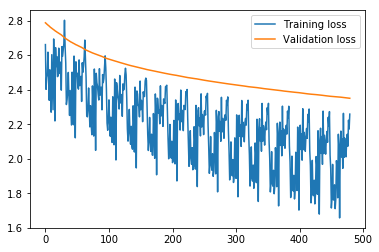

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()